In [1]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tqdm.auto as tqdm
from tqdm.contrib.concurrent import process_map

import postprocess

split_ratio = 0.3
seeds = range(33, 83)
data_dir = "data/communities"

max_workers = 32

/home/rxian/anaconda3/envs/fair-lite/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import scipy.spatial


def get_convex_hull_lower(x, y):
  # https://stackoverflow.com/a/76839030

  def get_lower(polygon):
    minx = np.argmin(polygon[:, 0])
    maxx = np.argmax(polygon[:, 0]) + 1
    if minx >= maxx:
      lower_curve = np.concatenate([polygon[minx:], polygon[:maxx]])
    else:
      lower_curve = polygon[minx:maxx]
    return lower_curve

  points = np.stack([x, y], axis=1)
  hull = scipy.spatial.ConvexHull(points)
  lower_curve = get_lower(points[hull.vertices])
  return lower_curve

## Download UCI Communities and Crime dataset

In [3]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names
features = [
    "state", "county", "community", "communityname", "fold", "population",
    "householdsize", "racepctblack", "racePctWhite", "racePctAsian",
    "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up",
    "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf",
    "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc",
    "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap",
    "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov",
    "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed",
    "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu",
    "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv",
    "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom",
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5",
    "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5",
    "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell",
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous",
    "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup",
    "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant",
    "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos",
    "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart",
    "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ",
    "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg",
    "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState",
    "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT",
    "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop",
    "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop",
    "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp",
    "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits",
    "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens",
    "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr",
    "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop",
    "ViolentCrimesPerPop"
]

data_path = f"{data_dir}/communities.data"
if not os.path.exists(data_path):
  os.makedirs(data_dir, exist_ok=True)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
      data_path)

,count,%
Group,,
black,970,0.486459
white,1024,0.513541


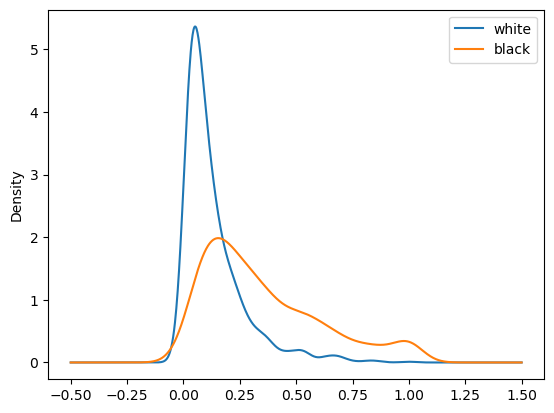

In [4]:
def data_transform(df):
  """Normalize features."""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


original = pd.read_csv(data_path,
                       names=features,
                       sep=r",",
                       engine="python",
                       na_values="?")

# Drop community name, state, and county, and columns with missing values
original = original.drop(["communityname", "state", "county"],
                         axis=1).dropna(axis=1)

# Transform data, and remove fold and target
data = original.copy()
data = data.drop(["ViolentCrimesPerPop", "fold"], axis=1)
data = data_transform(data)

targets = original["ViolentCrimesPerPop"].to_numpy()

groups = (original["racepctblack"] > 0.06).to_numpy().astype(int)
group_names = ["white", "black"]
n_groups = len(group_names)

bound = (0, 1)

# Show data statistics
df = pd.DataFrame(
    zip(np.array(group_names)[groups], targets),
    columns=["Group", "Target"],
).groupby(["Group"]).agg({"count"})
df.columns = df.columns.droplevel(0)
df["%"] = df["count"] / df["count"].sum()
display(df)

df = pd.DataFrame({
  name: pd.Series(targets[groups == a]) for a, name in enumerate(group_names)
}).plot.kde()

## Fair post-processing

In [5]:
# Helper functions


def ks_dist(scores, groups):
  """Maximum pairwise KS distance"""
  n_groups = len(np.unique(groups))
  max_ks = 0
  for i in range(n_groups):
    for j in range(i + 1, n_groups):
      max_ks = max(max_ks,
                   ks_2samp(scores[groups == i], scores[groups == j]).statistic)
  return max_ks


def postprocess_and_evaluate(k_alpha_eps_seed):
  """Post-processing and evaluation using multiple CPU cores"""
  k, alpha, eps, seed = k_alpha_eps_seed

  # Split into train and test
  _, _, train_targets, test_targets, train_groups, test_groups = train_test_split(
      data,
      targets,
      groups,
      test_size=split_ratio,
      random_state=seed,
  )

  # Post-process and evaluate
  postprocessor = postprocess.PrivateHDEFairPostProcessor().fit(
      train_targets,
      train_groups,
      alpha=alpha,
      eps=eps,
      bound=bound,
      n_bins=k,
      rng=np.random.default_rng(seed),
  )
  targets_test_fair = postprocessor.predict(test_targets, test_groups)
  return (mean_squared_error(test_targets, targets_test_fair),
          ks_dist(targets_test_fair, test_groups))

### Results and baselines for $\alpha = 0$

In [6]:
n_bins = 12
epsilons = [np.inf, 10, 5, 1, 0.5, 0.1]

# results[0] = mse
# results[1] = ks
# results[:, i] = methods[i]
results = np.empty((2, 3 + len(epsilons), len(seeds)))
methods = [
    "no postprocessing", "Chzhen et al. (2020)", "binning", "binning + fair"
] + [f"binning + private and fair (eps={eps})" for eps in epsilons[1:]]

for k, seed in enumerate(tqdm.tqdm(seeds)):

  # Split into train and test
  _, _, train_targets, test_targets, train_groups, test_groups = train_test_split(
      data,
      targets,
      groups,
      test_size=split_ratio,
      random_state=seed,
  )

  # No postprocessing
  results[0, 0, k] = 0
  results[1, 0, k] = ks_dist(test_targets, test_groups)

  # Chzhen et al. (2020)
  postprocessor = postprocess.WassersteinBarycenterFairPostProcessor().fit(
      train_targets,
      train_groups,
      rng=np.random.default_rng(seed),
  )
  targets_test_fair = postprocessor.predict(test_targets, test_groups)
  results[0, 1, k] = mean_squared_error(test_targets, targets_test_fair)
  results[1, 1, k] = ks_dist(targets_test_fair, test_groups)

  # Binning
  postprocessor = postprocess.PrivateHDEFairPostProcessor().fit(
      train_targets,
      train_groups,
      alpha=1.0,
      bound=bound,
      n_bins=n_bins,
      rng=np.random.default_rng(seed),
  )
  targets_test_fair = postprocessor.predict(test_targets, test_groups)
  results[0, 2, k] = mean_squared_error(test_targets, targets_test_fair)
  results[1, 2, k] = ks_dist(targets_test_fair, test_groups)

  # Binning + (private) fair postprocessing
  for i, eps in enumerate(epsilons):
    postprocessor = postprocess.PrivateHDEFairPostProcessor().fit(
        train_targets,
        train_groups,
        alpha=0.0,
        eps=eps,
        bound=bound,
        n_bins=n_bins,
        rng=np.random.default_rng(seed),
    )
    targets_test_fair = postprocessor.predict(test_targets, test_groups)
    results[0, 3 + i, k] = mean_squared_error(test_targets, targets_test_fair)
    results[1, 3 + i, k] = ks_dist(targets_test_fair, test_groups)

  0%|          | 0/50 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-29


100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


In [7]:
means = results.mean(axis=2)
stds = results.std(axis=2)
df = pd.DataFrame(np.stack([means[0], stds[0], means[1], stds[1]], axis=1))
df.columns = ["mse", "mse std", "ks", "ks std"]
df.index = methods
display(df)

,mse,mse std,ks,ks std
no postprocessing,0.000000,0.000000,0.457663,0.033567
Chzhen et al. (2020),0.018217,0.002057,0.097138,0.028541
binning,0.000562,0.000016,0.449961,0.035186
binning + fair,0.018486,0.001028,0.064075,0.024100
binning + private and fair (eps=10),0.018441,0.001079,0.064352,0.024214
binning + private and fair (eps=5),0.018396,0.001102,0.064654,0.025137
binning + private and fair (eps=1),0.018106,0.001894,0.068496,0.026381
binning + private and fair (eps=0.5),0.017691,0.003149,0.075991,0.031572
binning + private and fair (eps=0.1),0.015489,0.008970,0.162784,0.094371


### Vary $\alpha$

In [8]:
sweep_k = [12, 60]
epsilons = [np.inf, 10, 5, 1, 0.5, 0.1]
alphas = np.concatenate([
    [0.0],
    np.exp(np.linspace(np.log(0.005), np.log(0.12), 14)),
    np.linspace(0.13, 0.44, 12),
    [1.0],
])
print(f"alphas = {alphas}")

all_results = []
for eps in epsilons:
  results = process_map(
      postprocess_and_evaluate,
      [(k, alpha, eps, seed) for k in sweep_k for alpha in alphas
       for seed in seeds],
      max_workers=max_workers,
      chunksize=1,
  )  # shape = (len(sweep_k) * len(alphas) * len(seeds), 2)
  results = np.moveaxis(
      np.array(results).reshape(len(sweep_k), len(alphas), len(seeds), 2), -1,
      0)
  all_results.append(results)
all_results = np.moveaxis(
    np.array(all_results), 0,
    1)  # shape = (2, len(epsilons), len(sweep_k), len(alphas), len(seeds))

alphas = [0.         0.005      0.00638469 0.00815286 0.01041071 0.01329384
 0.01697542 0.02167657 0.02767966 0.03534523 0.04513369 0.05763296
 0.07359377 0.09397474 0.12       0.13       0.15818182 0.18636364
 0.21454545 0.24272727 0.27090909 0.29909091 0.32727273 0.35545455
 0.38363636 0.41181818 0.44       1.        ]


100%|██████████| 2800/2800 [00:10<00:00, 254.58it/s]


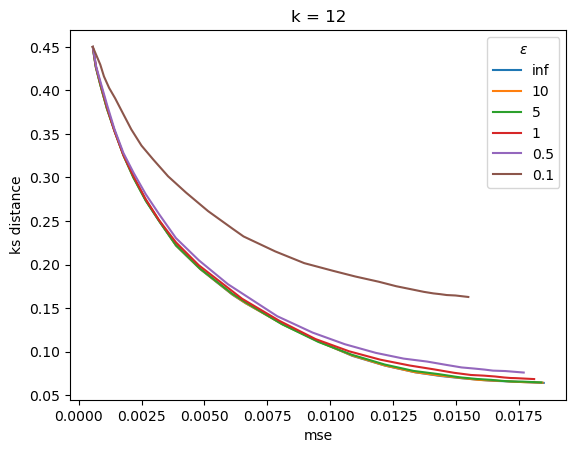

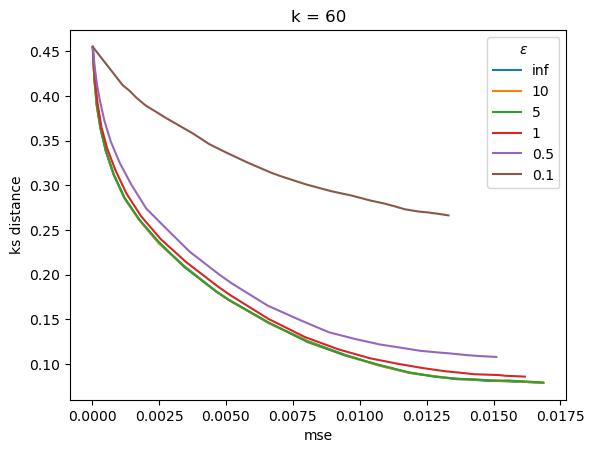

In [9]:
results_mean = all_results.mean(axis=-1)
for i, k in enumerate(sweep_k):
  fig, ax = plt.subplots(1, 1)
  for j, eps in enumerate(epsilons):
    ax.plot(*results_mean[:, j, i], label=f"{eps}")
  plt.legend(title=r"$\epsilon$")
  ax.set_xlabel("mse")
  ax.set_ylabel("ks distance")
  plt.title(f"k = {k}")
  plt.show()

### Sweep $k$ and $\alpha$ ($\epsilon=0.1$)

In [11]:
sweep_k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
eps = 0.1
alphas = np.concatenate([
    [0.0],
    np.exp(np.linspace(np.log(0.005), np.log(0.12), 14)),
    np.linspace(0.13, 0.44, 12),
    [1.0],
])
print(f"alphas = {alphas}")

results = process_map(
    postprocess_and_evaluate,
    [(k, alpha, eps, seed) for k in sweep_k for alpha in alphas
     for seed in seeds],
    max_workers=max_workers,
)  # shape = (len(sweep_k) * len(alphas) * len(seeds), 2)
results = np.moveaxis(
    np.array(results).reshape(len(sweep_k), len(alphas), len(seeds), 2), -1, 0)

alphas = [0.         0.005      0.00638469 0.00815286 0.01041071 0.01329384
 0.01697542 0.02167657 0.02767966 0.03534523 0.04513369 0.05763296
 0.07359377 0.09397474 0.12       0.13       0.15818182 0.18636364
 0.21454545 0.24272727 0.27090909 0.29909091 0.32727273 0.35545455
 0.38363636 0.41181818 0.44       1.        ]


/tmp/ipykernel_3657088/1022416811.py:11: TqdmWarning: Iterable length 21000 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  results = process_map(
100%|██████████| 21000/21000 [00:17<00:00, 1176.07it/s]


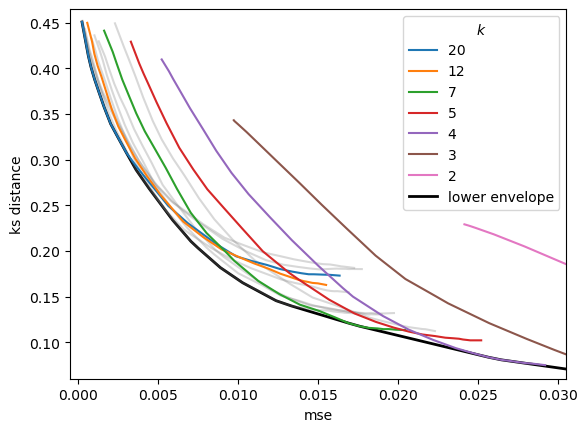

In [12]:
results_mean = results.mean(axis=-1)
fig, ax = plt.subplots(1, 1)
highlighted_k = [2, 3, 4, 5, 7, 12, 20]
for i, k in enumerate(sweep_k):
  if k not in highlighted_k:
    ax.plot(*results_mean[:, i], color="gray", alpha=0.3)
for i, k in list(enumerate(sweep_k))[::-1]:
  if k in highlighted_k:
    ax.plot(*results_mean[:, i], label=f"{k}")

ax.plot(*get_convex_hull_lower(*results_mean.reshape(2, -1)).T,
        color="k",
        label="lower envelope",
        lw=2,
        zorder=0)
plt.legend(title=r"$k$")
ax.set_xlabel("mse")
ax.set_ylabel("ks distance")
plt.xlim(-0.0005, 0.0305)
plt.ylim(0.06, 0.465)
plt.show()

### Lower envelopes

In [14]:
sweep_k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
epsilons = [np.inf, 10, 5, 1, 0.5, 0.1]
alphas = np.concatenate([
    [0.0],
    np.exp(np.linspace(np.log(0.005), np.log(0.12), 14)),
    np.linspace(0.13, 0.44, 12),
    [1.0],
])
print(f"alphas = {alphas}")

all_results = []
for eps in epsilons:
  results = process_map(
      postprocess_and_evaluate,
      [(k, alpha, eps, seed) for k in sweep_k for alpha in alphas
       for seed in seeds],
      max_workers=max_workers,
      chunksize=1,
  )  # shape = (len(sweep_k) * len(alphas) * len(seeds), 2)
  results = np.moveaxis(
      np.array(results).reshape(len(sweep_k), len(alphas), len(seeds), 2), -1,
      0)
  all_results.append(results)
all_results = np.moveaxis(
    np.array(all_results), 0,
    1)  # shape = (2, len(epsilons), len(sweep_k), len(alphas), len(seeds))

alphas = [0.         0.005      0.00638469 0.00815286 0.01041071 0.01329384
 0.01697542 0.02167657 0.02767966 0.03534523 0.04513369 0.05763296
 0.07359377 0.09397474 0.12       0.13       0.15818182 0.18636364
 0.21454545 0.24272727 0.27090909 0.29909091 0.32727273 0.35545455
 0.38363636 0.41181818 0.44       1.        ]


100%|██████████| 21000/21000 [00:37<00:00, 560.43it/s]


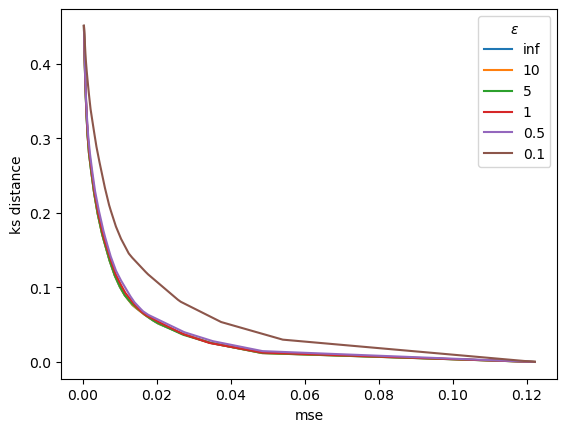

In [15]:
results_mean = all_results.mean(axis=-1)
fig, ax = plt.subplots(1, 1)
for i, eps in enumerate(epsilons):
  ax.plot(*get_convex_hull_lower(*results_mean[:, i].reshape(2, -1)).T,
          label=f"{eps}")
plt.legend(title=r"$\epsilon$")
ax.set_xlabel("mse")
ax.set_ylabel("ks distance")
plt.show()